Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


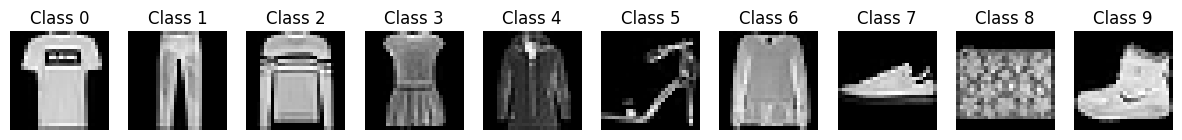

In [ ]:
from google.colab import drive
import numpy as np
import gzip
import matplotlib.pyplot as plt
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

drive.mount('/content/drive')

# Function to read the MNIST image data
def read_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, 28, 28)
    return data

# Function to read the MNIST label data
def read_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

drive_path = "/content/drive/My Drive//MNIST/"

# Load train and test images and labels
train_images = read_mnist_images(drive_path + 'train-images-idx3-ubyte.gz')
train_labels = read_mnist_labels(drive_path + 'train-labels-idx1-ubyte.gz')
test_images = read_mnist_images(drive_path + 't10k-images-idx3-ubyte.gz')
test_labels = read_mnist_labels(drive_path + 't10k-labels-idx1-ubyte.gz')

# Print one image from each class
classes = np.unique(train_labels)
num_classes = len(classes)
fig, axs = plt.subplots(1, num_classes, figsize=(15, 5))

for i, class_label in enumerate(classes):
    idx = np.where(train_labels == class_label)[0][0]
    image = train_images[idx]
    axs[i].imshow(image.reshape(28,28), cmap='gray')
    axs[i].set_title(f'Class {class_label}')
    axs[i].axis('off')

plt.show()





In [ ]:
# Reshape and normalize the image data
train_images = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images = test_images.reshape(test_images.shape[0], -1) / 255.0

# Print the shapes of the data arrays
print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Images Shape:", test_images.shape)
print("Test Labels Shape:", test_labels.shape)

# Concatenate train and test images and labels
combined_images = np.concatenate([train_images, test_images], axis=0)
combined_labels = np.concatenate([train_labels, test_labels], axis=0)

# Print the shapes of the combined data arrays
print("Combined Images Shape:", combined_images.shape)
print("Combined Labels Shape:", combined_labels.shape)


Train Images Shape: (60000, 784)
Train Labels Shape: (60000,)
Test Images Shape: (10000, 784)
Test Labels Shape: (10000,)
Combined Images Shape: (70000, 784)
Combined Labels Shape: (70000,)


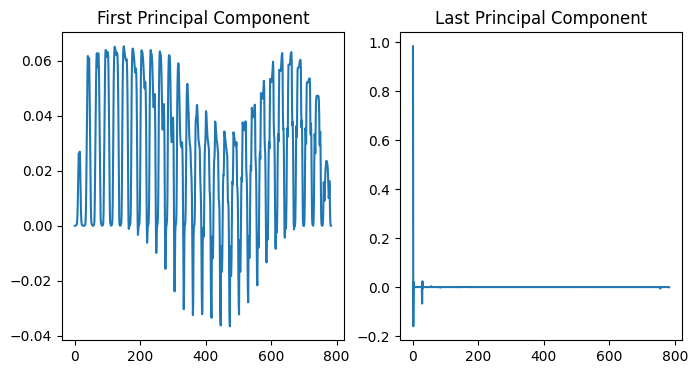

In [ ]:
# Function to perform PCA
def perform_pca(data, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(data)
    return pca.components_

# Perform PCA on the combined images
pca_components = perform_pca(combined_images, 784)

# Plot the first and last principal components
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(pca_components[0])
plt.title("First Principal Component")
plt.subplot(1, 2, 2)
plt.plot(pca_components[-1])
plt.title("Last Principal Component")
plt.show()




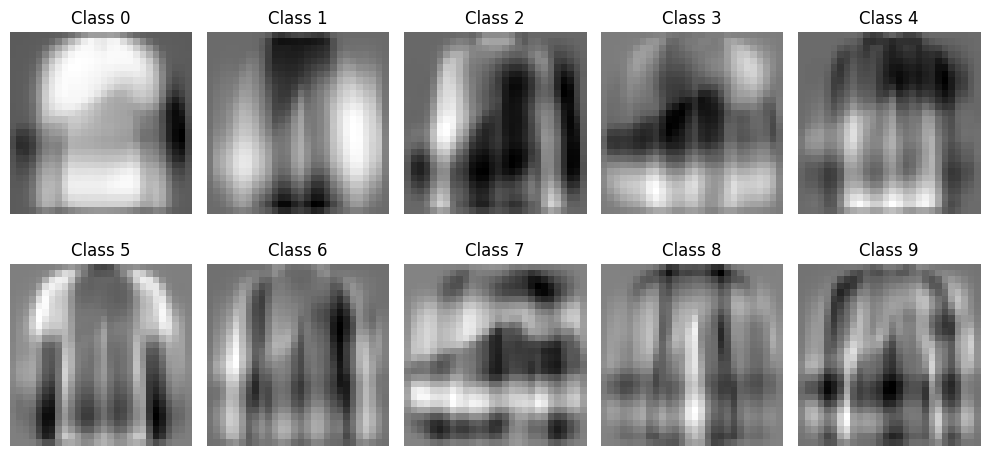

In [ ]:
# Perform PCA
pca = PCA(n_components=784)
pca.fit(combined_images)

# Sort principal components by explained variance
explained_variance_ratio_sorted = np.sort(pca.explained_variance_ratio_)[::-1]
explained_variance_sorted = np.sort(pca.explained_variance_)[::-1]
components_sorted = pca.components_[np.argsort(pca.explained_variance_ratio_)[::-1]]

components_sorted[:5]

components_sorted.shape

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(components_sorted[i].reshape(28, 28), cmap='gray')
    plt.title(f'Class {i}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Implementing Kennard-Stone algorithm with N=5810 (train test ratio 83:17)
def kennard_stone_split(data, labels, N_per_class):
    split_train_images = []
    split_train_labels = []
    split_test_images = []
    split_test_labels = []

    for class_label in np.unique(labels):
        class_indices = np.where(labels == class_label)[0]
        np.random.shuffle(class_indices)

        train_indices = class_indices[:N_per_class]
        test_indices = class_indices[N_per_class:N_per_class + 7000 - N_per_class]

        split_train_images.append(data[train_indices])
        split_train_labels.append(labels[train_indices])
        split_test_images.append(data[test_indices])
        split_test_labels.append(labels[test_indices])

    return np.concatenate(split_train_images), np.concatenate(split_train_labels), \
           np.concatenate(split_test_images), np.concatenate(split_test_labels)

# Using Kennard-Stone algorithm to split the data
N_per_class = 5810
train_images_kennard, train_labels_kennard, test_images_kennard, test_labels_kennard = \
    kennard_stone_split(combined_images, combined_labels, N_per_class)

# Perform PCA on the combined images
pca_components = perform_pca(combined_images, 188)

# Represent each image in the new basis of principal components
train_images_pca = np.dot(train_images_kennard, pca_components.T)
test_images_pca = np.dot(test_images_kennard, pca_components.T)

# Train k-nearest neighbors classifier
classifier = KNeighborsClassifier(n_neighbors=20, metric='manhattan')
classifier.fit(train_images_pca, train_labels_kennard)

# Predict labels for test data
predicted_labels = classifier.predict(test_images_pca)

# Calculate accuracy for each digit and overall accuracy
overall_accuracy = accuracy_score(test_labels_kennard, predicted_labels)
class_accuracies = {}
for class_label in np.unique(combined_labels):
    class_indices = np.where(test_labels_kennard == class_label)[0]
    class_accuracy = accuracy_score(test_labels_kennard[class_indices], predicted_labels[class_indices])
    class_accuracies[class_label] = class_accuracy

# Print overall accuracy and class-wise accuracy
print("Overall Accuracy: {:.2f} %".format(overall_accuracy * 100))
print("Class-wise Accuracy:")
for class_label, accuracy in class_accuracies.items():
    print("Class {}: {:.2f} %".format(class_label, accuracy * 100))


Overall Accuracy: 86.18 %
Class-wise Accuracy:
Class 0: 89.75 %
Class 1: 96.97 %
Class 2: 77.56 %
Class 3: 87.65 %
Class 4: 79.33 %
Class 5: 83.19 %
Class 6: 61.51 %
Class 7: 95.55 %
Class 8: 94.20 %
Class 9: 96.13 %
